# Small Personal study: FGSM-attack

The foolowing document contains implementation of Fast Gradient Sign method on PyTorch for MNIST dataset. It also contains experimental results for some propositions mentioned in the main document.

## Importing libraries, defining necessary functions, donwloading dataset

In [61]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# function that creates adversarial examples
# args: image, epsilon, network
# returns: perturbed image
def fgsm_attack(image, label, epsilon, net):
    net.zero_grad()
    image.requires_grad_(True)
    output = net(image.view(-1, 784))
    label = torch.tensor([label])
    loss = F.nll_loss(output, label)
    loss.backward()

    # get the gradient of the input image data
    gradients = image.grad.data

    # get sign of the gradients
    sign_data_grad = gradients.sign()
    # add perturbation to the input image data
    perturbed_image = image + epsilon * sign_data_grad

    perturbed_image.detach_().numpy()

    return perturbed_image

In [20]:
def perturb_set(epsilon, net, set):
    perturbed_set = []
    for data in set:
        X, y = data
        for idx, img in enumerate(X):
            perturbed_image = fgsm_attack(img, y[idx], epsilon, net)
            perturbed_set.append((perturbed_image, y[idx]))
    perturbed_set = torch.utils.data.DataLoader(perturbed_set, batch_size=10, shuffle=True)
    return perturbed_set

In [24]:
# find loss and accuracy on a given set
def test_set(net, set):
    correct = 0
    total = 0
    loss = 0
    # no_grad() tells PyTorch that we do not need to keep track of the gradients of the Tensor
    with torch.no_grad():
        for data in set:
            X, y = data
            output = net(X.view(-1, 784))
            # get the index of the max log-probability
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1
                loss += F.nll_loss(i, y[idx], reduction='sum').item()
    return correct/total, loss/total

In [3]:
# create the neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(28*28, 64)
        # hidden layer
        self.fc2 = nn.Linear(64, 64)
        # output layer
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # output layer
        x = self.fc3(x)
        # softmax for probability distribution
        return F.log_softmax(x, dim=1)
    
net = Net()

In [33]:
# create a deeper neural network
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(28*28, 128)
        # hidden layer
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        # output layer
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        # activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # output layer
        x = self.fc4(x)
        # softmax for probability distribution
        return F.log_softmax(x, dim=1)
    
deep_net = DeepNet()

In [38]:
# create very deep neural network
class VeryDeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(28*28, 256)
        # hidden layer
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        # output layer
        self.fc6 = nn.Linear(256, 10)

    def forward(self, x):
        # activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        # output layer
        x = self.fc6(x)
        # softmax for probability distribution
        return F.log_softmax(x, dim=1)
    
very_deep_net = VeryDeepNet()

In [47]:
# define function to train the neural network on the training set
def train(network, train_set, EPOCHS = 3):
    print("Training...")
    # define optimizer and loss function
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(EPOCHS):
        for data in train_set:
            # data is a batch of featuresets and labels
            X, y = data
            # set gradients to zero
            network.zero_grad()
            # feedforward
            output = network(X.view(-1, 784))
            # calculate loss
            loss = F.nll_loss(output, y)
            # backpropagation
            loss.backward()
            # update weights
            optimizer.step()
        print("Epoch: ", epoch, " Loss: ", loss)
    return network

In [4]:
# load the data
train = datasets.MNIST("", train=True, download=True,
                          transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", train=False, download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))
# batch size
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)

testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

100%|██████████| 9912422/9912422 [00:13<00:00, 758522.04it/s]


Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 274958.45it/s]


Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw



100%|██████████| 1648877/1648877 [00:02<00:00, 810080.79it/s]


Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw



## Demonstration of the FGSM_attack

### shallow net

In [49]:
# train the neural network
net = Net()
net = train(net, trainset)



Training...
Epoch:  0  Loss:  tensor(0.0135, grad_fn=<NllLossBackward0>)
Epoch:  1  Loss:  tensor(0.0113, grad_fn=<NllLossBackward0>)
Epoch:  2  Loss:  tensor(0.0040, grad_fn=<NllLossBackward0>)


In [50]:
# test the neural network
accuracy, loss = test_set(net, testset)
print("Accuracy: ", accuracy, " Loss: ", loss)

Accuracy:  0.9714  Loss:  0.09477071026984109


Label:  4
Confidence:  tensor(0.9993, grad_fn=<ExpBackward0>)


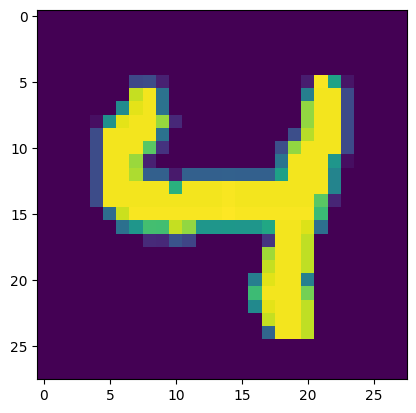

In [51]:
# extract one sample from the test set
m = np.random.randint(0, len(testset))
target, label = test[m][0], test[m][1]

print("Label: ", label)
# outout confidence
print("Confidence: ", torch.exp(net(target.view(-1, 784))[0][label]))

plt.imshow(target.view(28, 28))
plt.show()


Predicted label:  9
Confidence:  0.6892493


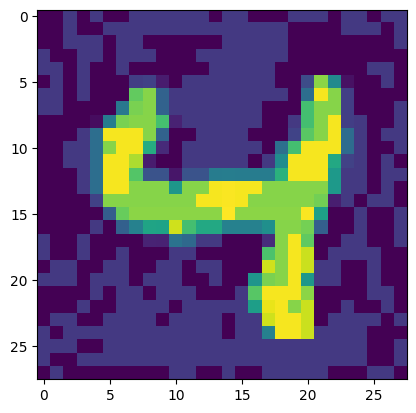

In [52]:
# create adversarial example
epsilon = 0.1
perturbed_image = fgsm_attack(target, label, epsilon, net)

# predict the label of the perturbed image
with torch.no_grad():
    output = net(perturbed_image.view(-1, 784))
    label_hat = torch.argmax(output[0])
    label_hat.detach_().numpy()
    label_hat = np.array(label_hat)
    print("Predicted label: ", label_hat)

# calculate the confidence of the perturbed image
conf = torch.exp(net(perturbed_image.view(-1, 784))[0][torch.argmax(output[0])])
conf.detach_().numpy()
conf = np.array(conf)
print("Confidence: ", conf)


plt.imshow(perturbed_image.view(28, 28))
plt.show()

### deep net

In [53]:
# train the deeper neural network
deep_net = DeepNet()
deep_net = train(deep_net, trainset)

Training...
Epoch:  0  Loss:  tensor(0.0966, grad_fn=<NllLossBackward0>)
Epoch:  1  Loss:  tensor(0.0108, grad_fn=<NllLossBackward0>)
Epoch:  2  Loss:  tensor(0.0569, grad_fn=<NllLossBackward0>)


In [54]:
# test the deeper neural network
accuracy, loss = test_set(deep_net, testset)
print("Accuracy: ", accuracy, " Loss: ", loss)

Accuracy:  0.969  Loss:  0.1018958797130057


### very deep net

In [55]:
#train the very deep neural network
very_deep_net = VeryDeepNet()
very_deep_net = train(very_deep_net, trainset)

Training...
Epoch:  0  Loss:  tensor(0.8049, grad_fn=<NllLossBackward0>)
Epoch:  1  Loss:  tensor(0.0028, grad_fn=<NllLossBackward0>)
Epoch:  2  Loss:  tensor(0.0005, grad_fn=<NllLossBackward0>)


In [56]:
# test the very deep neural network
accuracy, loss = test_set(very_deep_net, testset)
print("Accuracy: ", accuracy, " Loss: ", loss)

Accuracy:  0.9662  Loss:  0.13897860755663288


## Experiments!

In [36]:
#experiments on the shallow neural network
epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
losses = []

for eps in epsilons:
    perturbed_testset = perturb_set(eps, net, testset)
    acc, loss = test_set(net, perturbed_testset)
    accuracies.append(acc)
    losses.append(loss)
    print("Epsilon: ", eps, " Accuracy: ", acc, " Loss: ", loss)

Epsilon:  0  Accuracy:  0.9698  Loss:  0.09654396894673786
Epsilon:  0.05  Accuracy:  0.283  Loss:  3.6768475018598865
Epsilon:  0.1  Accuracy:  0.0462  Loss:  9.883431238494353
Epsilon:  0.15  Accuracy:  0.0095  Loss:  15.498676455980684
Epsilon:  0.2  Accuracy:  0.0017  Loss:  21.143059165212772
Epsilon:  0.25  Accuracy:  0.0008  Loss:  26.982874314370523
Epsilon:  0.3  Accuracy:  0.0005  Loss:  33.01870201804373


In [37]:
# experiments on the deeper neural network
accuracies_deep = []
losses_deep = []

for eps in epsilons:
    perturbed_testset = perturb_set(eps, deep_net, testset)
    acc, loss = test_set(deep_net, perturbed_testset)
    accuracies_deep.append(acc)
    losses_deep.append(loss)
    print("Epsilon: ", eps, " Accuracy: ", acc, " Loss: ", loss)

Epsilon:  0  Accuracy:  0.972  Loss:  0.10156138586854055
Epsilon:  0.05  Accuracy:  0.4777  Loss:  2.8267144519292087
Epsilon:  0.1  Accuracy:  0.1218  Loss:  8.20329291720969
Epsilon:  0.15  Accuracy:  0.0267  Loss:  13.073753389636114
Epsilon:  0.2  Accuracy:  0.0051  Loss:  17.82083519847639
Epsilon:  0.25  Accuracy:  0.001  Loss:  22.68777793702748
Epsilon:  0.3  Accuracy:  0.0003  Loss:  27.78232026530921


In [41]:
# experiments on the very deep neural network
accuracies_very_deep = []
losses_very_deep = []

for eps in epsilons:
    perturbed_testset = perturb_set(eps, very_deep_net, testset)
    acc, loss = test_set(very_deep_net, perturbed_testset)
    accuracies_very_deep.append(acc)
    losses_very_deep.append(loss)
    print("Epsilon: ", eps, " Accuracy: ", acc, " Loss: ", loss)

Epsilon:  0  Accuracy:  0.9721  Loss:  0.1101242087440847
Epsilon:  0.05  Accuracy:  0.4922  Loss:  2.564095586610514
Epsilon:  0.1  Accuracy:  0.0947  Loss:  7.194056847447209
Epsilon:  0.15  Accuracy:  0.0156  Loss:  10.843324249255192
Epsilon:  0.2  Accuracy:  0.0018  Loss:  14.374131875404716
Epsilon:  0.25  Accuracy:  0.0001  Loss:  18.235175692820548
Epsilon:  0.3  Accuracy:  0.0  Loss:  22.491549004650118


In [62]:
#experiment hyperparameters
epsilons = [0, .05, .1, .15, .2, .25, .3]
k = 3 # number of experiments per network_type

In [63]:
results = pd.DataFrame({"Epsilon": [],  "net_type": [], "net_id":[], "Accuracy": [], "Loss": []})

for epsilon in epsilons:
    for i in range(k):
        print("Epsilon: ", epsilon, " Experiment: ", i)

        #experiment on the shallow neural network
        print("Shallow")
        net = Net()
        net = train(net, trainset)
        perturbed_testset = perturb_set(epsilon, net, testset)
        acc, loss = test_set(net, perturbed_testset)
        #use concat to append the results to the dataframe
        results = pd.concat([results, pd.DataFrame({"Epsilon": epsilon, "net_type": "shallow", "net_id": i, "Accuracy": acc, "Loss": loss}, index=[0])], ignore_index=True)

        #experiment on the deeper neural network
        print("Deep")
        deep_net = DeepNet()
        deep_net = train(deep_net, trainset)
        perturbed_testset = perturb_set(epsilon, deep_net, testset)
        acc, loss = test_set(deep_net, perturbed_testset)
        results = pd.concat([results, pd.DataFrame({"Epsilon": epsilon, "net_type": "deep", "net_id": i, "Accuracy": acc, "Loss": loss}, index=[0])], ignore_index=True)

        #experiment on the very deep neural network
        print("Very Deep")
        very_deep_net = VeryDeepNet()
        very_deep_net = train(very_deep_net, trainset)
        perturbed_testset = perturb_set(epsilon, very_deep_net, testset)
        acc, loss = test_set(very_deep_net, perturbed_testset)
        results = pd.concat([results, pd.DataFrame({"Epsilon": epsilon, "net_type": "very_deep", "net_id": i, "Accuracy": acc, "Loss": loss}, index=[0])], ignore_index=True)

results.to_csv("results.csv", index=False)

Epsilon:  0  Experiment:  0
Shallow
Training...
Epoch:  0  Loss:  tensor(0.0780, grad_fn=<NllLossBackward0>)
Epoch:  1  Loss:  tensor(0.0026, grad_fn=<NllLossBackward0>)
Epoch:  2  Loss:  tensor(0.0186, grad_fn=<NllLossBackward0>)
Deep
Training...
Epoch:  0  Loss:  tensor(0.0021, grad_fn=<NllLossBackward0>)
Epoch:  1  Loss:  tensor(0.0066, grad_fn=<NllLossBackward0>)
Epoch:  2  Loss:  tensor(0.0101, grad_fn=<NllLossBackward0>)
Very Deep
Training...
Epoch:  0  Loss:  tensor(0.6218, grad_fn=<NllLossBackward0>)
Epoch:  1  Loss:  tensor(0.0223, grad_fn=<NllLossBackward0>)
Epoch:  2  Loss:  tensor(0.0048, grad_fn=<NllLossBackward0>)
Epsilon:  0  Experiment:  1
Shallow
Training...
Epoch:  0  Loss:  tensor(0.0752, grad_fn=<NllLossBackward0>)
Epoch:  1  Loss:  tensor(0.1203, grad_fn=<NllLossBackward0>)
Epoch:  2  Loss:  tensor(0.1975, grad_fn=<NllLossBackward0>)
Deep
Training...
Epoch:  0  Loss:  tensor(0.2817, grad_fn=<NllLossBackward0>)
Epoch:  1  Loss:  tensor(0.0340, grad_fn=<NllLossBackwa

## Results

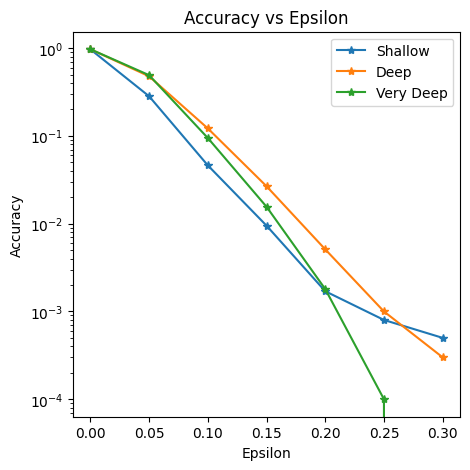

In [44]:
# plot the results
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.plot(epsilons, accuracies_deep, "*-")
plt.plot(epsilons, accuracies_very_deep, "*-")
plt.title("Accuracy vs Epsilon")
#logarithmic scale
plt.yscale('log')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(["Shallow", "Deep", "Very Deep"])
plt.show()

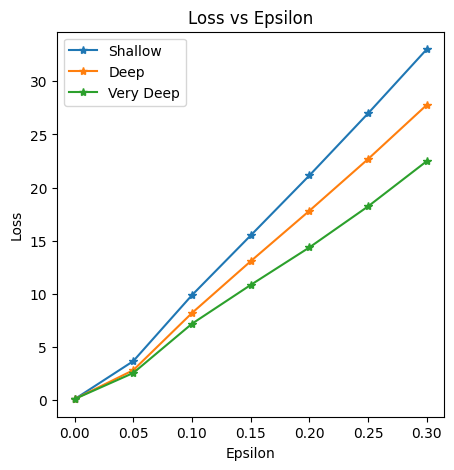

In [43]:
# plot the results
plt.figure(figsize=(5,5))
plt.plot(epsilons, losses, "*-")
plt.plot(epsilons, losses_deep, "*-")
plt.plot(epsilons, losses_very_deep, "*-")
plt.title("Loss vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Loss")
plt.legend(["Shallow", "Deep", "Very Deep"])
plt.show()

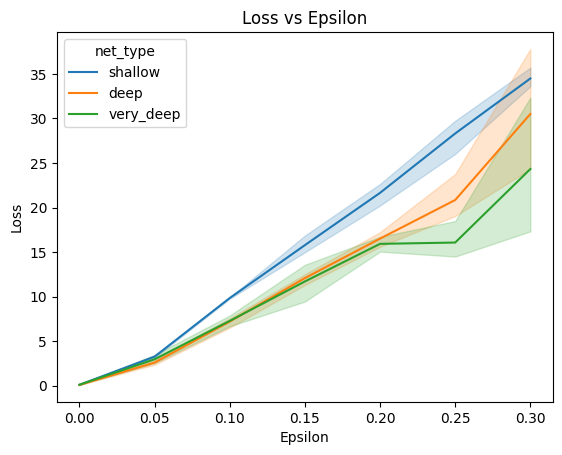

In [68]:
# plot loss vs epsilon
results = pd.read_csv("results.csv")
sns.lineplot(x="Epsilon", y="Loss", hue="net_type", data=results)
plt.title("Loss vs Epsilon")
plt.show()

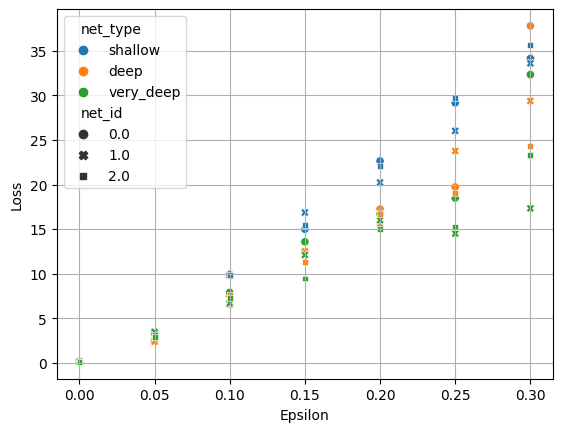

In [72]:
sns.scatterplot(x="Epsilon", y="Loss", hue="net_type", style="net_id", data=results)
plt.grid()

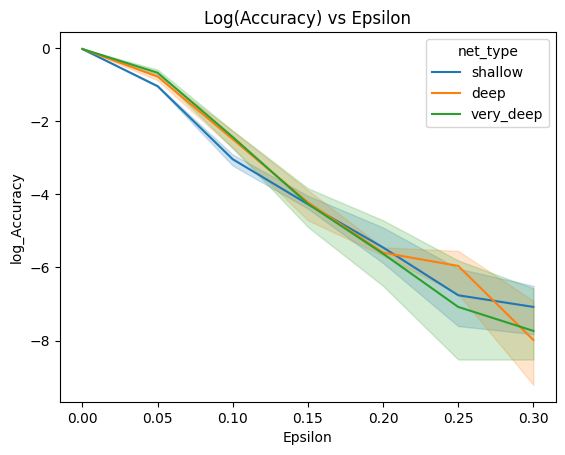

In [66]:
#plot log(acc) vs epsilon
results = pd.read_csv("results.csv")
results["log_Accuracy"] = np.log(results["Accuracy"])
sns.lineplot(x="Epsilon", y="log_Accuracy", hue="net_type", data=results)
plt.title("Log(Accuracy) vs Epsilon")
plt.show()